### Importacion de librerías necesarias para el proyecto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

##### Cargar el modelo entrenado en el primer archivo (proyecto_lluvia)

In [2]:

model = joblib.load('modelo_lluvia')  # Asegúrate de que el nombre del archivo sea correcto

Debido a que tuve problemas con los días mas lluviosos a consecuencia seguramente de las escasas precipitaciones en españa tuve que buscar algo de informacion de paises en el norte y para adecuar el csv alos que tenía de españa he tenido que hacera parte los cambios para eliminar columnas y otros cambios que os muestro en el siguiente código

In [3]:


'''Cargar el archivo CSV, luego eliminamos las columnas 
inecesarias y convertimos la columna date a tipo de fecha. Creamos 
las columnas separadas para año y el mes
sumamos la precipitacion diaria para obtener la mensual'''

df_norte = pd.read_csv('nordics_weather.csv')


df_norte = df_norte.drop(columns=['snow_depth', 'tavg', 'tmax', 'tmin'])

df_norte['date'] = pd.to_datetime(df_norte['date'])

df_norte['ano'] = df_norte['date'].dt.year
df_norte['mes'] = df_norte['date'].dt.month

df_mensual = df_norte.groupby(['country', 'ano', 'mes']).agg({'precipitation': 'sum'}).reset_index()

'''Obtenemos columnas separadas para cada mes y cambiamos el nombre de la columna coutry
a region para que coincida.
Agregamos la columna parámetro con el valor de precipitación.
Calculamos la columna anual como la suma de las precipitaciones de los meses y
reorganizamos el orden de las columnas y antes cambip los nombres de las columnas 1 a 12 por los nombre de  las meses''' 

df_mensual = df_mensual.pivot_table(index=['country', 'ano'], columns='mes', values='precipitation', fill_value=0).reset_index()

df_mensual.rename(columns={'country': 'region'}, inplace=True)

df_mensual['Parametro'] = 'Precipitacion'

df_mensual['anual'] = df_mensual[list(range(1, 13))].sum(axis=1)

meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
df_mensual.rename(columns=dict(zip(range(1, 13), meses)), inplace=True)

column_order = ['Parametro', 'region'] + meses + ['anual']

df_mensual = df_mensual[column_order]

# Guardamos el DataFrame resultante en un archivo CSV
df_mensual.to_csv('nordics_weather_transformed.csv', index=False)




Cargamos los datos incluyendo el que hemos preparado en el código anterior, preparamos los datos
creamos el modelo, en éste caso de clasificación y lo entrenamos
realizamos el reporte de clasificacion

In [4]:
'''Cargamos los datos desde los archivos CSV de 2019, 2020 y 2021 y creamos el df inicial en el caso que no esté definido
llenamos los valores nulos con la media de columna
combinamos los datos antiguos y nuevos
Predecimos el valor anual de lluvia usando el modelo de regresión'''

df_1981 = pd.read_csv('PREC_1981_2010_Provincias.csv', delimiter=';')
df_2019 = pd.read_csv('PREC_2019_Provincias.csv', delimiter=';')
df_2020 = pd.read_csv('PREC_2020_Provincias.csv', delimiter=';')
df_2021 = pd.read_csv('PREC_2021_Provincias.csv', delimiter=';')
df_2022 = pd.read_csv('PREC_2022_Provincias.csv', delimiter=';')
df_paises_del_norte = pd.read_csv('nordics_weather_transformed.csv', delimiter=',')

if 'df' not in locals():
    df = pd.DataFrame()
df.fillna(df.mean(), inplace=True)

df = pd.concat([df, df_2019, df_2020, df_2021,df_1981,df_2022,df_paises_del_norte], ignore_index=True)

df['anual_predicho'] = model.predict(df[['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']])

# Ajustar umbrales manuales para determinar el estado climático
umbral_sequia = 400.0 # Establecer un valor bajo para la sequía
umbral_inundacion = 1000.0  # Establecer un valor alto para la inundación

# Creamos una columna "estado_climatico" basada en los nuevos umbrales usando if
df['estado_climatico'] = 'Normal'  # Inicializar con 'Normal'
df.loc[df['anual_predicho'] < umbral_sequia, 'estado_climatico'] = 'Sequía'
df.loc[df['anual_predicho'] > umbral_inundacion, 'estado_climatico'] = 'Inundación'


'''Dividimos los datos en características (X) y etiquetas (y)
después los dividimos en conjunto de entrenamiento y prueba
Creamos el modelo de regresión Logística y realizamos las predicciones.
Evaluamos el rendimiento con classification_report()'''

X = df[['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']]
y = df['estado_climatico']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo_clasificacion = LogisticRegression(random_state=42)
modelo_clasificacion.fit(X_train, y_train)

y_pred = modelo_clasificacion.predict(X_test)

reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion)


              precision    recall  f1-score   support

  Inundación       0.40      0.50      0.44         4
      Normal       0.78      0.68      0.72        37
      Sequía       0.50      0.64      0.56        14

    accuracy                           0.65        55
   macro avg       0.56      0.61      0.58        55
weighted avg       0.68      0.65      0.66        55



C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


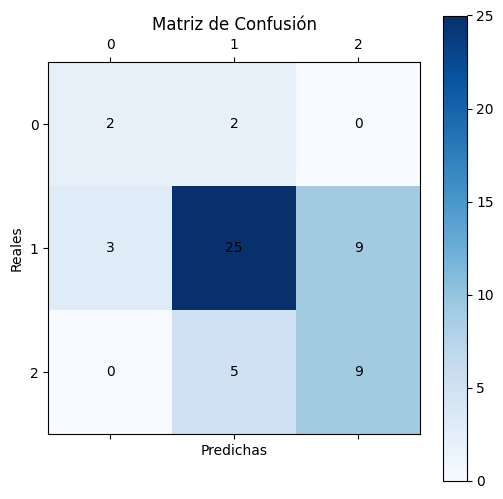

Accuracy: 0.6545454545454545
Precision: 0.6819318181818183
Recall: 0.6545454545454545
F1-score: 0.6629885814668424


In [5]:
'''Para la Matriz de confusión encontré algunos ejemplos por internet y youtube 
y hubo uno que me encantó y lo adapteé aquí porque me parece que está genial
y explica muy bien la propia matriz'''

def visualiza_metricas(y_reales, y_predichas, titulo):
    matriz_confusion = confusion_matrix(y_reales, y_predichas)
    accuracy = accuracy_score(y_reales, y_predichas)
    precision = precision_score(y_reales, y_predichas, average='weighted')
    recall = recall_score(y_reales, y_predichas, average='weighted')
    f1 = f1_score(y_reales, y_predichas, average='weighted')

    plt.figure(figsize=(6, 6))
    plt.matshow(matriz_confusion, cmap="Blues", fignum=1)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predichas")
    plt.ylabel("Reales")
    plt.colorbar()

    for i in range(matriz_confusion.shape[0]):
        for j in range(matriz_confusion.shape[1]):
            plt.text(j, i, str(matriz_confusion[i, j]), va='center', ha='center')

    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

# Realizamos predicciones en el conjunto de prueba
y_pred_clases = modelo_clasificacion.predict(X_test)

# Visualizamos las métricas y la matriz de confusión
visualiza_metricas(y_test, y_pred, "Métricas de Clasificación")


## Pruebas
#### Estos son pruebas con datos inventados que estuve haciendo para ver bien los comportamientos y
decidí dejarlos porque ayudan al entendimiento de:
* creacion de vectores
* predicciones usando el modelo de clasificación y traducir el resultado de clasificación en una etiqueta legible
* volver a utilizar predicciones con el moidelo de regresión

In [6]:
nuevo_dato = np.array([13.4, 57.9, 13.9, 28.4, 18.6, 11.1, 2.0, 6.1, 6.8, 15.6, 3.6, 11.5]).reshape(1, -1)

nuevo_dato2 = np.array([191.0, 148.9, 128.4, 139.1, 117.5, 58.9, 36.0, 43.5, 93.8, 212.0, 217.2, 241.0]).reshape(1, -1)

nuevo_dato3 = np.array([31.2, 45.5, 34.8, 20.9, 10.3, 2.7, 23.1, 8.9, 7.6, 5.8, 1.4, 10.2]).reshape(1, -1)

bergen = np.array([190.0, 152.0, 170.0, 114.0, 106.0, 132.0, 148.0, 190.0, 283.0, 271.0, 259.0, 235.0]).reshape(1, -1)

lista_datos = [nuevo_dato, nuevo_dato2, nuevo_dato3, bergen]

for datos in lista_datos:
    resultado_clasificacion = modelo_clasificacion.predict(datos)
    
    if resultado_clasificacion[0] == 'Normal':
        condicion_climatica = 'Condiciones Normales'
    elif resultado_clasificacion[0] == 'Inundación':
        condicion_climatica = 'Posible Inundación'
    else:
        condicion_climatica = 'Sequía'
    
    print(f"Predicción de Condiciones Climáticas (Clasificación): {condicion_climatica}")
    
   

# Realizar la predicción usando el modelo de regresión
resultado_regresion = model.predict(nuevo_dato2)
    
print(f"Predicción de Valor Anual de Lluvia (Regresión): {round(resultado_regresion[0],1)}")

Predicción de Condiciones Climáticas (Clasificación): Condiciones Normales
Predicción de Condiciones Climáticas (Clasificación): Posible Inundación
Predicción de Condiciones Climáticas (Clasificación): Sequía
Predicción de Condiciones Climáticas (Clasificación): Posible Inundación
Predicción de Valor Anual de Lluvia (Regresión): 1627.3


C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Funciones de apoyo
#### Para facilitar arreglos de datos he creado varias funciones al crear datos de otros lados o distintas fuentes

* ###### convertir_df_a_np(dataframe) --> Convierte el DataFrame a un arreglo NumPy y luego aplana en una sola fila
* ###### convertir_np_a_data(np) --> función para convertir los arrays a dataframe para la función analizar_datos_lista()
* ###### analizar_datos_lista(lista_dataframes, umbral_sequia=100.0, umbral_lluvia_excepcional=300.0) --> Función que crea estadísticas de precipitación, luego identifica el mes de sequía y la lluvia excepcional, creamos un diccionario de colores para la leyenda de un gráfico que creará por la precipitación por mes y retornando los resultados.

In [7]:

def convertir_df_a_np(dataframe):
    arreglo_np = dataframe.to_numpy().flatten()
    return arreglo_np

def convertir_np_a_data(np):
    lst = list(np[0])
    lst_float = [float(x) for x in lst]  # Convierte los elementos a float
    return {'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'], 'precipitacion': lst_float}

#Funcion que tomo argumentos lista y los dos umbrales
def analizar_datos_lista(lista_dataframes, umbral_sequia=100.0, umbral_lluvia_excepcional=300.0):
    resultados_por_dataset = []

    for df in lista_dataframes:
        promedio = df['precipitacion'].mean()
        mes_mas_lluvioso = df['mes'][df['precipitacion'].idxmax()]
        mes_menos_lluvioso = df['mes'][df['precipitacion'].idxmin()]

        df['estado'] = np.where(df['precipitacion'] < umbral_sequia, 'Sequía',
                                np.where(df['precipitacion'] > umbral_lluvia_excepcional, 'Lluvia Excepcional',
                                         'Normal'))

        colores = {'Sequía': 'red', 'Lluvia Excepcional': 'blue', 'Normal': 'green'}

        plt.figure(figsize=(10, 6))
        for estado, color in colores.items():
            plt.bar(df['mes'][df['estado'] == estado], df['precipitacion'][df['estado'] == estado], color=color, label=estado)

        plt.xlabel('Mes')
        plt.ylabel('Precipitación (mm)')
        plt.title('Precipitación Mensual')
        plt.xticks(rotation=45)

        plt.legend()

        plt.show()
        resultados = {
            'promedio': promedio,
            'mes_mas_lluvioso': mes_mas_lluvioso,
            'mes_menos_lluvioso': mes_menos_lluvioso
        }
        resultados_por_dataset.append(resultados)

    return resultados_por_dataset

## Ejemplos y pruebas

#### Creo ejemlpos sólo para probar las funciones con datos totalmente ficticios
 Creo 3 dataframes y los meto en una lista para poder aplicarle la última función y ver como funciona


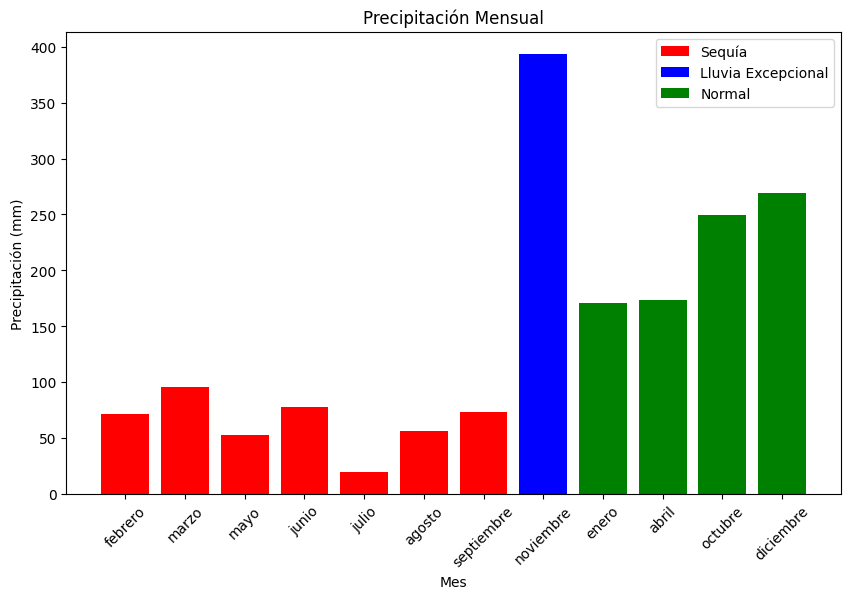

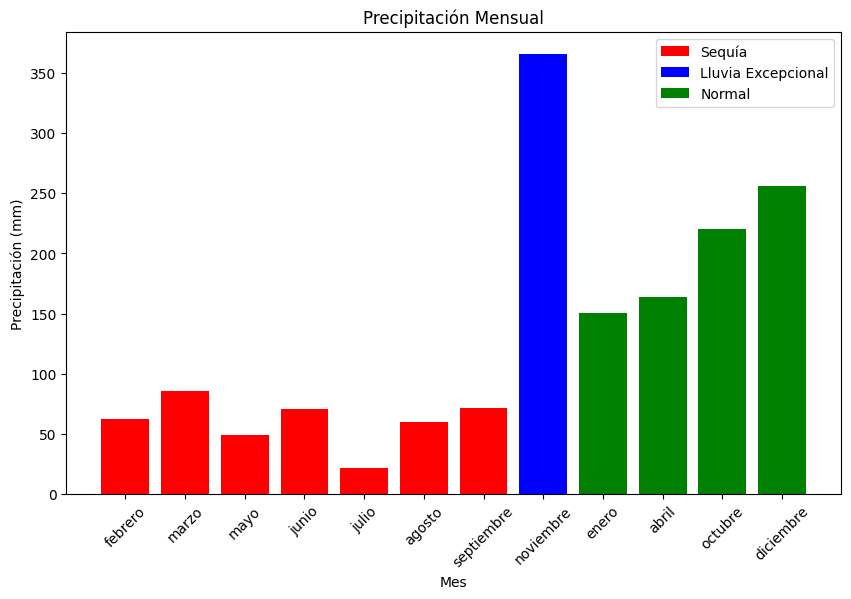

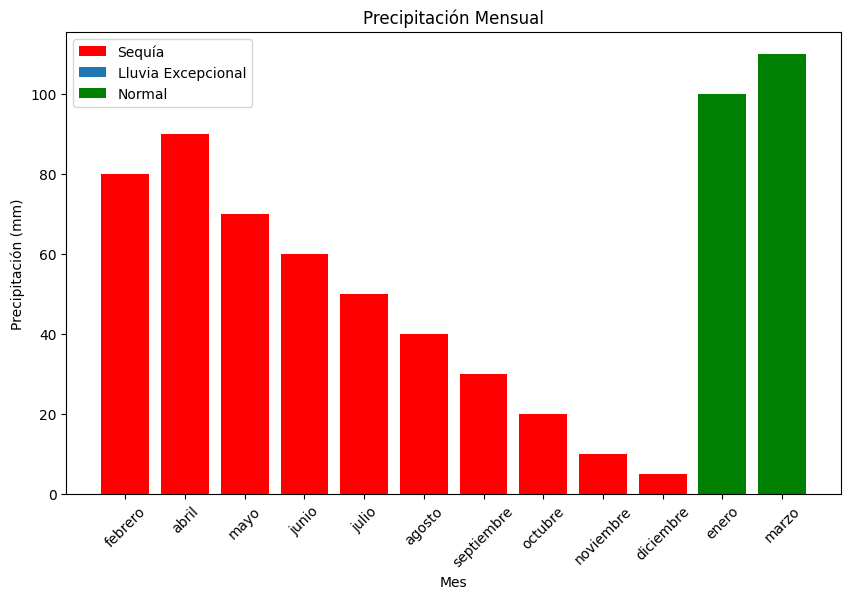

Resultados para el Dataset 1:
Promedio: 142.08333333333334
Mes más lluvioso: noviembre
Mes menos lluvioso: julio

Resultados para el Dataset 2:
Promedio: 131.275
Mes más lluvioso: noviembre
Mes menos lluvioso: julio

Resultados para el Dataset 3:
Promedio: 55.416666666666664
Mes más lluvioso: marzo
Mes menos lluvioso: diciembre



In [8]:
data1 = {
    'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    'precipitacion': [171.2, 72.0, 96.1, 173.7, 52.9, 78.2, 19.6, 56.6, 73.2, 249.4, 393.3, 268.8]
}

data2 = {
    'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    'precipitacion': [150.2, 62.5, 85.3, 163.8, 48.9, 70.4, 21.3, 60.0, 71.5, 220.1, 365.5, 255.8]
}

data3 = {
    'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    'precipitacion': [100.0, 80.0, 110.0, 90.0, 70.0, 60.0, 50.0, 40.0, 30.0, 20.0, 10.0, 5.0]
}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

lista_de_dataframes = [df1, df2, df3]


resultados = analizar_datos_lista(lista_de_dataframes)

for i, resultado in enumerate(resultados, start=1):
    print(f"Resultados para el Dataset {i}:")
    print(f"Promedio: {resultado['promedio']}")
    print(f"Mes más lluvioso: {resultado['mes_mas_lluvioso']}")
    print(f"Mes menos lluvioso: {resultado['mes_menos_lluvioso']}\n")

Introduce la ciudad a analizar: Málaga


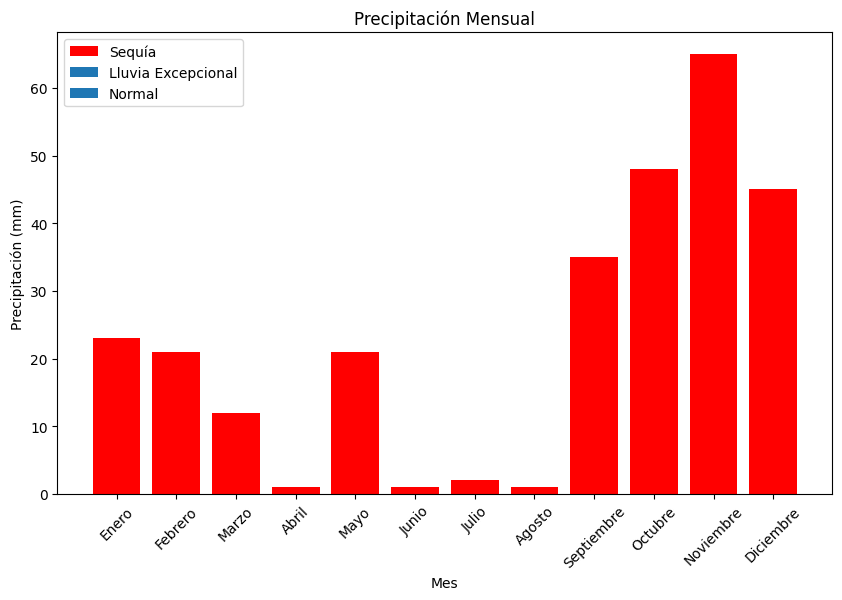

Resultados para la Ciudad Málaga:
Promedio: 22.916666666666668 mm
Mes más lluvioso: Noviembre
Mes menos lluvioso: Abril

La ciudad introducida no ha sido declarada. ejecute:Proyecto_Final_IA_01, para crear el csv de la ciudad 


In [9]:
'''Función que viene para los modelos que crea la interfaz gráfica de Proyecto_Final_IA_01,
Mezclamos un poco las funciones diseñadas anteriormente
Primero crea una lista de Dataframes que incluye el dataframe del cliente
Luego convertimos el dataframe en un arreglo numpy
Realizamos la prediccion usando el modelo de clasificación y lo traducimo a una forma legible
Cuando se solicita la ciudad que es la que pasará como argumento a la función crea:analisis(ciudad)
en el caso que no se halla creado con la interfaz te retornará un mensaje como que esa ciudad no ha sido declarada.'''



def crea_analisis(ciudad):
    try:
        lista_datos = [pd.read_csv(ciudad+'.csv')]

        resultados2 = analizar_datos_lista(lista_datos)

        for resultado in resultados2:
            print(f"Resultados para la Ciudad {ciudad}:")
            print(f"Promedio: {resultado['promedio']} mm")
            print(f"Mes más lluvioso: {resultado['mes_mas_lluvioso']}")
            print(f"Mes menos lluvioso: {resultado['mes_menos_lluvioso']}\n"
           )

        #____________________________________modelo_clasificacion    
        datos_prueba2 = datos_cliente['precipitacion'].values.reshape(1, -1)
        lista_datos2 = []
        lista_datos2.append(datos_prueba2)
        for datos in lista_datos2:
            resultado_clasificacion = modelo_clasificacion.predict(datos)

            if resultado_clasificacion[0] == 'Normal':
                condicion_climatica = 'Condiciones Normales'
            elif resultado_clasificacion[0] == 'Inundación':
                condicion_climatica = 'Posible Inundación'
            else:
                condicion_climatica = 'Sequía' 
            print(f"Predicción de Condiciones Climáticas: {condicion_climatica} por el mes de {resultado['mes_mas_lluvioso']}") 
    except NameError:
            print('La ciudad introducida no ha sido declarada. ejecute:Proyecto_Final_IA_01, para crear el csv de la ciudad ')
            
if __name__ == "__main__":
    ciudad_requerida=input('Introduce la ciudad a analizar: ')
    crea_analisis(ciudad_requerida.capitalize())